In [1]:
import os

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from functools import lru_cache
from typing import List, Optional, Dict, Any
from serpapi import GoogleSearch

@lru_cache(maxsize=None)
def search_flights(
    origin: str,
    destination: str,
    departure_date: str,
    return_date: Optional[str]) -> dict:
    """
    Search flights between two airports using SerpAPI Google Flights and return available options.
    """
    params = {
        "api_key": os.environ["SERPAPI_API_KEY"],
        "engine": "google_flights",
        "hl": "en",
        "gl": "th",
        "departure_id": origin.strip().upper(),
        "arrival_id": destination.strip().upper(),
        "outbound_date": departure_date,
        "return_date": return_date,
        "currency": "THB"
    }
    
    results = GoogleSearch(params).get_dict()
    return results


@lru_cache(maxsize=None)
def search_hotels(
    destination: str, 
    check_in_date: str, 
    check_out_date: str) -> dict:
    """
    Search hotels in a location using SerpAPI Google Hotels and return available options.
    """
    
    params = {
        "api_key": os.environ["SERPAPI_API_KEY"],
        "engine": "google_hotels",
        "hl": "en",
        "gl": "th",
        "q": destination,
        "check_in_date": check_in_date,
        "check_out_date": check_out_date,
        "currency": "THB",
        "sort_by": 3,
        "rating": 8
    }
    
    results = GoogleSearch(params).get_dict()
    return results

In [4]:
from langchain_core.tools import tool

@tool
def search_flights_tool(
    origin: str,
    destination: str,
    departure_date: str,
    return_date: Optional[str]) -> dict:
    """
    Search for flights using Google Flights API
    
    Args:
        origin: Origin airport code or city
        destination: Destination airport code or city
        departure_date: Departure date (YYYY-MM-DD)
        return_date: Return date (YYYY-MM-DD)
    
    Returns:
        Dict containing flight search results
    """
    try:
        results = search_flights(
            origin=origin,
            destination=destination,
            departure_date=departure_date,
            return_date=return_date
        )
        
        flights = []
        if "best_flights" in results:
            for flight in results["best_flights"][:5]:  # Top 5 flights
                flights.append({
                    "airline": flight.get("flights", [{}])[0].get("airline", "Unknown"),
                    "price": flight.get("price", "N/A"),
                    "duration": flight.get("total_duration", "N/A"),
                    "departure_time": flight.get("flights", [{}])[0].get("departure_airport", {}).get("time", "N/A"),
                    "arrival_time": flight.get("flights", [{}])[-1].get("arrival_airport", {}).get("time", "N/A"),
                    "stops": len(flight.get("flights", [])) - 1,
                    "travel_class": flight.get("flights", [{}])[0].get("travel_class", "N/A"),
                    # "return_date":
                    # "airline_logo":
                })
        
        return {
            "flights": flights,
            "search_metadata": {
                "origin": origin,
                "destination": destination, 
                "departure_date": departure_date,
                "return_date": return_date
            }
        }
        
    except Exception as e:
        return {"error": f"Flight search failed: {str(e)}", "flights": []}

In [5]:
@tool
def search_hotels_tool(
    destination: str,
    check_in_date: str,
    check_out_date: str) -> dict:
    """
    Search for hotels using Google Hotels API
    
    Args:
        location: Hotel destination
        check_in_date: Check-in date (YYYY-MM-DD)
        check_out_date: Check-out date (YYYY-MM-DD)
        budget: Optional budget per night
        
    Returns:
        Dict containing hotel search results
    """
    try:
        results = search_hotels(
            destination=destination,
            check_in_date=check_in_date,
            check_out_date=check_out_date
        )
        
        hotels = []
        if "properties" in results:
            for hotel in results["properties"][:5]:  # Top 5 hotels
                hotels.append({
                    "name": hotel.get("name", "Unknown"),
                    "price": hotel.get("rate_per_night", {}).get("lowest", "N/A"),
                    "rating": hotel.get("overall_rating", "N/A"),
                    "location": hotel.get("nearby_places", "N/A"),
                    "amenities": hotel.get("amenities", []),
                    "link": hotel.get("link", "N/A")
                })
        
        return {
            "hotels": hotels,
            "search_metadata": {
                "destination": destination,
                "check_in_date": check_in_date,
                "check_out_date": check_out_date,
                # "budget": budget
            }
        }
        
    except Exception as e:
        return {"error": f"Hotel search failed: {str(e)}", "hotels": []}

In [6]:
@tool
def extract_travel_details(user_request: str) -> Dict[str, str]:
    """
    Extract travel details from user request using LLM
    
    Args:
        user_request: Raw user travel request
        
    Returns:
        Dict with extracted travel details
    """
    # This would typically use an LLM to extract structured data
    # For demo purposes, returning a simple extraction
    return {
        "origin": "Bangkok",
        "destination": "Chiang Mai", 
        "departure_date": "2025-09-20",
        "return_date": "2025-09-22",
        "budget": "150000",
        "travelers": "2"
    }
    
    
extract_travel_details.invoke("I want to go to Chiang Mai from Bangkok on 2024-04-20 and return on 2024-04-22")

{'origin': 'Bangkok',
 'destination': 'Chiang Mai',
 'departure_date': '2025-09-20',
 'return_date': '2025-09-22',
 'budget': '150000',
 'travelers': '2'}

In [64]:
from pydantic import BaseModel, Field
from typing import List, Optional, Dict, Any, Annotated

    
    
class ItinearyAgentState(BaseModel):
    
    origin: str
    destination: str
    departure_date: str      # format: YYYY-MM-DD
    return_date: str         # format: YYYY-MM-DD
    
    flight_options: List[Dict[str, Any]] = None
    hotel_options: List[Dict[str, Any]] = None
    
    flight_data: Optional[str] = None
    hotel_data: Optional[str] = None
    
    itinerary: Optional[str] = None
    

In [19]:
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


llm = ChatOpenAI(model="gpt-4", temperature=0)

In [20]:
flight_agent_instructions = """

Your are AI expert that provides in-depth analysis comparing flight options based on multiple factors. Analyze flight options and recommend the best one considering price, duration, stops, and overall convenience.

Recommend the best flight from the available options, based on the details provided below:

**Reasoning for Recommendation:**
- **Price:** Provide a detailed explanation about why this flight offers the best value compared to others.
- **Duration:** Explain why this flight has the best duration in comparison to others.
- **Stops:** Discuss why this flight has minimal or optimal stops.
- **Travel Class:** Describe why this flight provides the best comfort and amenities.

Use the provided flight data as the basis for your recommendation. Be sure to justify your choice using clear reasoning for each attribute. Do not repeat the flight details in your response.
"""

In [21]:
hotel_agent_instructions = """

Your are AI expert that provides in-depth analysis comparing hotel options based on multiple factors. Analyze hotel options and recommend the best one considering price, rating, location, and amenities.

Based on the following analysis, generate a detailed recommendation for the best hotel. Your response should include clear reasoning based on price, rating, location, and amenities.

**AI Hotel Recommendation**
We recommend the best hotel based on the following analysis:

**Reasoning for Recommendation**:
- **Price:** The recommended hotel is the best option for the price compared to others, offering the best value for the amenities and services provided.
- **Rating:** With a higher rating compared to the alternatives, it ensures a better overall guest experience. Explain why this makes it the best choice.
- **Location:** The hotel is in a prime location, close to important attractions, making it convenient for travelers.
- **Amenities:** The hotel offers amenities like Wi-Fi, pool, fitness center, free breakfast, etc. Discuss how these amenities enhance the experience, making it suitable for different types of travelers.

**Reasoning Requirements**:
- Ensure that each section clearly explains why this hotel is the best option based on the factors of price, rating, location, and amenities.
- Compare it against the other options and explain why this one stands out.
- Provide concise, well-structured reasoning to make the recommendation clear to the traveler.
- Your recommendation should help a traveler make an informed decision based on multiple factors, not just one.
"""



In [22]:
agent = create_react_agent(
    model=llm,
    tools=[search_flights_tool],
    prompt=flight_agent_instructions
)

agent.invoke(
    {
        "messages": [
            HumanMessage(content="I want to go to CNX from BKK on 2025-09-20 and return on 2025-09-22")
        ]
    }
)

{'messages': [HumanMessage(content='I want to go to CNX from BKK on 2025-09-20 and return on 2025-09-22', additional_kwargs={}, response_metadata={}, id='52943281-1146-4898-8fee-311d59bebef5'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1RUJo9hSL6fi1pcgrtRUG5K7', 'function': {'arguments': '{\n"origin": "BKK",\n"destination": "CNX",\n"departure_date": "2025-09-20",\n"return_date": "2025-09-22"\n}', 'name': 'search_flights_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 312, 'total_tokens': 360, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-CH5GefrTvcJgsAx6IG8TPTwfS7sa3', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--

In [23]:
def get_filight_options(state: ItinearyAgentState):
    input_dict = {
        "origin": state.origin,
        "destination": state.destination,
        "departure_date": state.departure_date,
        "return_date": state.return_date
    }
    
    result = search_flights_tool.invoke(input_dict)
    return {"flight_options": result.get("flights", [])}


def get_hotel_options(state: ItinearyAgentState):
    input_dict = {
        "destination": state.destination,
        "check_in_date": state.departure_date,
        "check_out_date": state.return_date
    }
    
    result = search_hotels_tool.invoke(input_dict)
    return {"hotel_options": result.get("hotels", [])}


In [34]:
def get_flight_recommendation(state: ItinearyAgentState):
    flight_options = state.flight_options
    
    messages = [SystemMessage(content=flight_agent_instructions),
                HumanMessage(content=f"Flight options: {flight_options}")]
    
    
    recommended_flight = llm.invoke(messages)
    
    return {"flight_data": recommended_flight.content}


def get_hotel_recommendation(state: ItinearyAgentState):
    hotel_options = state.hotel_options
    
    messages = [SystemMessage(content=hotel_agent_instructions),
                HumanMessage(content=f"Hotel options: {hotel_options}")]
    
    recommended_hotel = llm.invoke(messages)
    
    return {"hotel_data": recommended_hotel.content}
    

In [65]:
from datetime import datetime

def generate_itinerary(state: ItinearyAgentState):
    
    flight_data = state.flight_data
    hotel_data = state.hotel_data
    
    destination = state.destination
    departure_date = state.departure_date
    return_date = state.return_date
    
    days = (datetime.strptime(state.return_date, "%Y-%m-%d") - datetime.strptime(state.departure_date, "%Y-%m-%d")).days
    
    
    planner_agent_instructions = f"""
Your are an AI Travel Planner Expert that create a detailed itinerary for the user based on flight and hotel information.

Based on the following details, create a {days}-day itinerary for the user:

The itinerary should include:
- Flight arrival and departure information
- Hotel check-in and check-out details
- Day-by-day breakdown of activities
- Must-visit attractions and estimated visit times
- Restaurant recommendations for meals
- Tips for local transportation
- Estimated daily expenses 💰 and total trip cost

**Format Requirements**:
- Use markdown formatting with clear headings (# for main headings, ## for days, ### for sections)
- Include emojis for different types of activities ( for landmarks, 🍽️ for restaurants, etc.)
- Use bullet points for listing activities
- Include estimated timings for each activity
- Include estimated cost for each activity, meal, and transportation
- Include total estimated cost at the end of the itinerary
- Format the itinerary to be visually appealing and easy to read
"""
    
    user_message = f"""

**Flight Details**:
{flight_data}

**Hotel Details**:
{hotel_data}

**Destination**: {destination}

**Travel Dates**: {departure_date} to {return_date} ({days} days)
"""

    
    messages = [
        SystemMessage(content=planner_agent_instructions),
        HumanMessage(content=user_message)
    ]
    
    result = llm.invoke(messages)
    
    print(result)
    
    return {"itinerary": result.content}


In [66]:
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display

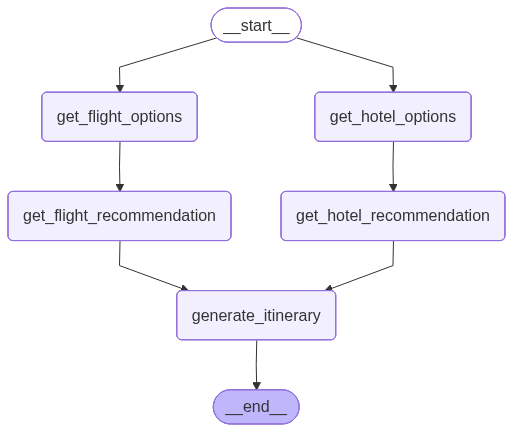

In [67]:
builder = StateGraph(ItinearyAgentState)

builder.add_node("get_flight_options", get_filight_options)
builder.add_node("get_hotel_options", get_hotel_options)

builder.add_node("get_flight_recommendation", get_flight_recommendation)
builder.add_node("get_hotel_recommendation", get_hotel_recommendation)

builder.add_node("generate_itinerary", generate_itinerary)

builder.add_edge(START, "get_flight_options")
builder.add_edge(START, "get_hotel_options")

builder.add_edge("get_flight_options", "get_flight_recommendation")
builder.add_edge("get_hotel_options", "get_hotel_recommendation")

builder.add_edge("get_flight_recommendation", "generate_itinerary")
builder.add_edge("get_hotel_recommendation", "generate_itinerary")

builder.add_edge("generate_itinerary", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [68]:
initial_state = ItinearyAgentState(
    origin="BKK",
    destination="CNX",
    departure_date="2025-09-20",
    return_date="2025-09-22"
)

result = graph.invoke(initial_state)

content="# 2-Day Itinerary for Chiang Mai, Thailand 🇹🇭\n\n## Day 1: Arrival and Exploration 🛬\n\n### Morning\n- Arrival at Chiang Mai International Airport (CNX) via Thai Vietjet Air at 22:50\n  - Estimated cost: 2619 THB 💰\n- Taxi ride to '84 gallery hostel' (10 minutes)\n  - Estimated cost: 150 THB 💰\n\n### Night\n- Check-in at '84 gallery hostel'\n  - Estimated cost: 324 THB/night 💰\n- Rest and freshen up for the next day's activities\n\n## Day 2: Full Day of Sightseeing 🏞️\n\n### Morning\n- Breakfast at the hostel\n  - Estimated cost: Included in the hotel price\n- Visit Wat Phra Singh (8:00 - 10:00)\n  - Estimated cost: 50 THB 💰\n- Visit Wat Chedi Luang (10:30 - 12:30)\n  - Estimated cost: 40 THB 💰\n\n### Afternoon\n- Lunch at Khao Soi Khun Yai (12:45 - 13:45) 🍽️\n  - Estimated cost: 100 THB 💰\n- Visit Chiang Mai City Arts & Cultural Centre (14:00 - 16:00)\n  - Estimated cost: 90 THB 💰\n\n### Evening\n- Visit Night Bazaar (18:00 - 20:00)\n  - Estimated cost: Free (excluding shoppi

In [69]:
result.keys()

dict_keys(['origin', 'destination', 'departure_date', 'return_date', 'flight_options', 'hotel_options', 'flight_data', 'hotel_data', 'itinerary'])

In [70]:
from IPython.display import Markdown, display


# display(Markdown(result.get('flight_data')))
# display(Markdown(result.get('hotel_data')))
display(Markdown(result.get('itinerary')))

# 2-Day Itinerary for Chiang Mai, Thailand 🇹🇭

## Day 1: Arrival and Exploration 🛬

### Morning
- Arrival at Chiang Mai International Airport (CNX) via Thai Vietjet Air at 22:50
  - Estimated cost: 2619 THB 💰
- Taxi ride to '84 gallery hostel' (10 minutes)
  - Estimated cost: 150 THB 💰

### Night
- Check-in at '84 gallery hostel'
  - Estimated cost: 324 THB/night 💰
- Rest and freshen up for the next day's activities

## Day 2: Full Day of Sightseeing 🏞️

### Morning
- Breakfast at the hostel
  - Estimated cost: Included in the hotel price
- Visit Wat Phra Singh (8:00 - 10:00)
  - Estimated cost: 50 THB 💰
- Visit Wat Chedi Luang (10:30 - 12:30)
  - Estimated cost: 40 THB 💰

### Afternoon
- Lunch at Khao Soi Khun Yai (12:45 - 13:45) 🍽️
  - Estimated cost: 100 THB 💰
- Visit Chiang Mai City Arts & Cultural Centre (14:00 - 16:00)
  - Estimated cost: 90 THB 💰

### Evening
- Visit Night Bazaar (18:00 - 20:00)
  - Estimated cost: Free (excluding shopping) 💰
- Dinner at Lemongrass Thai Restaurant (20:30 - 21:30) 🍽️
  - Estimated cost: 200 THB 💰

## Day 3: Departure 🛫

### Morning
- Breakfast at the hostel
  - Estimated cost: Included in the hotel price
- Check-out from '84 gallery hostel'
- Taxi ride to Chiang Mai International Airport (CNX) (10 minutes)
  - Estimated cost: 150 THB 💰

### Afternoon
- Departure from Chiang Mai International Airport (CNX) via Thai Vietjet Air at 14:00
  - Estimated cost: Included in the initial flight cost

# Total Estimated Cost 💰
- Flights: 2619 THB
- Accommodation: 648 THB (2 nights)
- Meals: 300 THB
- Attractions: 180 THB
- Transportation: 300 THB
- Total: 4047 THB

# Tips 📝
- Use local taxis or Grab for transportation. They are affordable and convenient.
- Try local street food at the Night Bazaar. It's delicious and cheap.
- Respect local customs at temples. Dress modestly and remove shoes before entering.

Enjoy your trip to Chiang Mai! 🎉